In [1]:
# goal: try to calculate relative vorticity either through metpy or a manual calculation! 
# in theory, this should be easy, but it's a bit harder... metpy isn't behaving with the unevenly spaced fl data
# trying to manipulate the xarray coords to give lat lon as inputs! but it's not really working

In [1]:
import os
import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt
import math
import metpy.calc as mpcalc
import pandas as pd

In [7]:
# load a test dataset
os.chdir( "/Users/etmu9498/research/data/in-situ-noaa-trimmed/2021/")
fl_data = xr.open_dataset( "20210929H2_sam_processed.nc")

#########
## update: xarray is being way too tedious to work with, so relative vorticity will have to be calculated manually :/
## doing that below
## use the definition found in kossin and eastin 2001 to do this!
#########

vtan = fl_data['WS.d'].values # tangential velocity
r = fl_data['center_dist'].values * 1000 # radial distance from the tc center, km -> m

rel_vort = []
# find relative vorticity for every velocity point! except the last to avoid i+1 error
for i in range( len( vtan) - 1):
    vi = vtan[ i] # current vtan
    vi1 = vtan[ i+1] # the next vtan value
    vavg = (vi + vi1) / 2
    
    ri = r[ i] # current radial distance
    ri1 = r[ i+1] # next radial distance
    ravg = (ri + ri1) / 2
    
    rel_vort.append( vavg / ravg + (vi1 - vi)/(ri1 - ri) )
    
# add one last nan value to get arrays to be the same size again!
rel_vort.append( np.nan)

# check out the output!
print( len( rel_vort))
print( np.nanmax( rel_vort))
print( np.nanmin( rel_vort))

print( np.nanmin( rel_vort))

# replace relative vorticity values larger than 1 with nans! these results are unphysical and likely due to large jumps 
# in radial distance or total vel
rel_vort = np.array( rel_vort)
rel_vort[ np.where( rel_vort > 1)[0]] = np.nan

# smooth the relative vorticity data to remove peaks!
rel_vort = pd.Series( rel_vort).rolling(window = 14, min_periods=1, center=True).mean()

# double smooth the data?? kinda looks nice!
# rel_vort = pd.Series( rel_vort).rolling(window = 20, min_periods=1, center=True).mean()



# correct units (from s-1 to *10^-4 s-1)
rel_vort = rel_vort * 10000

35528
197.52718544860724
-2.142184231341377
-2.142184231341377


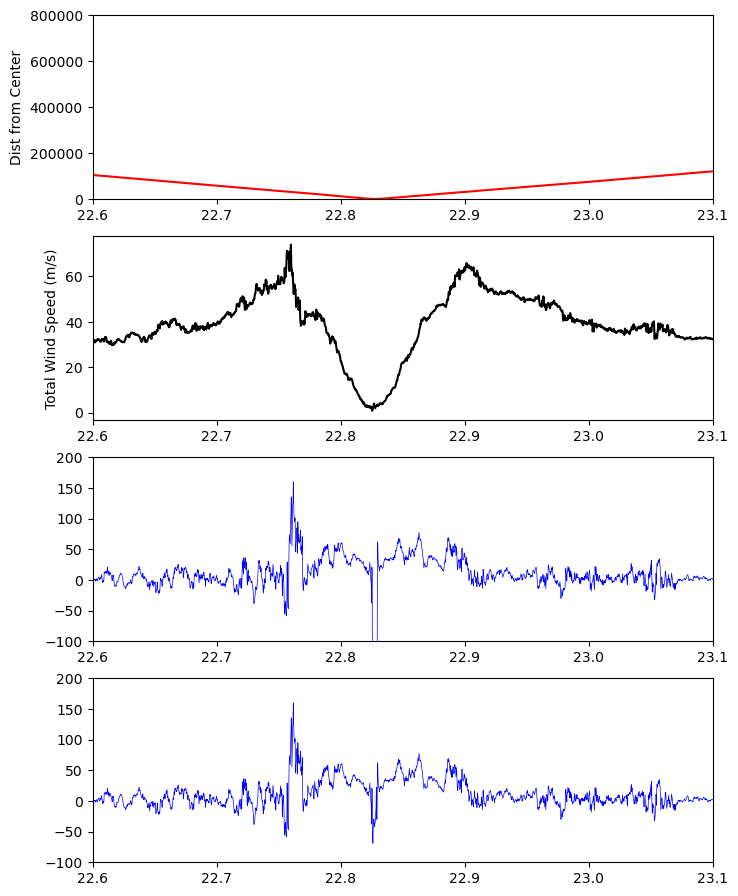

In [8]:
# plot things
plt.figure( figsize=(8, 11))

xlim = [22.6, 23.1]

# xlim = [21.5, 21.8]

ylim = [-100, 200]

plt.subplot( 411)
plt.plot( fl_data.time, r, c='r')
plt.ylabel( "Dist from Center")
plt.ylim( [ 0, 800000])
if xlim:
    plt.xlim( xlim)

plt.subplot( 412)
plt.plot( fl_data.time, vtan, c='k')
plt.ylabel( "Total Wind Speed (m/s)")
if xlim:
    plt.xlim( xlim)

plt.subplot(413)
plt.plot( fl_data.time, rel_vort, c='b', linewidth=.5, label='just calculated')
plt.ylim( ylim)
if xlim:
    plt.xlim( xlim)
    
plt.subplot(414)
plt.plot( fl_data.time, fl_data.rel_vort, c='b', linewidth=.5, label='from nc file')
plt.ylim( ylim)
if xlim:
    plt.xlim( xlim)

In [ ]:
# old attempts using metpy below... it didn't work :/ # 

In [8]:
# try creating a whole new dataset!
lon = fl_data.LONref
lat = fl_data.LATref

# add new fields to the dataset!
dvs = {}

input_vars = list( fl_data.keys())

print( input_vars)

for namei, nameval in enumerate( input_vars):
    # add this field to the dataframe!
    dvs.update( { nameval: ('lon', 'lat', fl_data[nameval].values) })


# next step: create the dataset and update units for existing variables!
fl_new = xr.Dataset( data_vars=dvs, coords={'lon': lon, 'lat': lat})

for fieldi, fieldval in enumerate( fl_new.variables):
    if fieldval in fl_data.variables:
        attribs = fl_data[ fieldval].attrs
        # add units, etc metadata present in the original flight level dataset!
        if 'units' in attribs:
            fl_new[fieldval].attrs['units'] = fl_data[ fieldval].units
        if 'Description' in attribs:
            fl_new[fieldval].attrs['Description'] = fl_data[ fieldval].Description
        if 'SampleRate' in attribs:
            fl_new[fieldval].attrs['SampleRate'] = fl_data[ fieldval].SampleRate
        if 'OutputRate' in attribs:
            fl_new[fieldval].attrs['OutputRate'] = fl_data[ fieldval].OutputRate
        if 'ValidRange' in attribs:
            fl_new[fieldval].attrs['ValidRange'] = fl_data[ fieldval].ValidRange
        if 'Min' in attribs:
            fl_new[fieldval].attrs['Min'] = fl_data[ fieldval].Min
        if 'Max' in attribs:
            fl_new[fieldval].attrs['Max'] = fl_data[ fieldval].Max


['HT.d', 'THETA.d', 'THETAV.d', 'WS.d', 'WD.d', 'UWZ.d', 'UWX.d', 'UWY.d', 'HUM_REL.d', 'SfmrRainRate.1', 'THETAE.d', 'MR.d', 'TA.d', 'PSURF.d', 'LATref', 'LONref', 'rmw', 'center_dist', 'rel_vort']


ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): ('lon', 'lat', array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)) to Variable.

In [13]:
# add latitude and longitude as coordinates!
fl_data = fl_data.assign_coords( {'lon': fl_data.LONref}) #  lon=('lon', fl_data.LONref.values)) # ( alternate_sample_weights=('samples', np.zeros(5)))
fl_data = fl_data.assign_coords( {'lat': fl_data.LATref})
fl_data = fl_data.drop( 'time')
fl_data

<xarray.Dataset>
Dimensions:         (time: 35528)
Coordinates:
    lon             (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    lat             (time) float32 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: time
Data variables: (12/18)
    HT.d            (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    THETA.d         (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    THETAV.d        (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    WS.d            (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    WD.d            (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    UWZ.d           (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...              ...
    TA.d            (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    PSURF.d         (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    LATref          (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    LONref          (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    rmw             (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    center_dist     (time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Author:       Created by NOAA HRD. Link to data: https://www.aoml.noaa.go...
    Editor:       Edited by: Ethan Murray (etmu9498@colorado.edu)
    Attribution:  This Dataset is based off the dataset 20210929H2_sam.nc. Pl...
    Note:         These data have been limited to P-3 heights between 2.5 km ...

In [6]:
print( fl_data['UWX.d'].coords)

print( np.nanmax( fl_data['lon']))
print( np.nanmin( fl_data['lon']))

# explore x and y velocity data!
print( np.nanmax(fl_data['UWX.d']))
print( np.nanmin(fl_data['UWX.d']))

print( len( fl_data['UWX.d']))
print( len( np.where( ~ np.isnan( fl_data['UWX.d'] ))[0] ))

print( len( fl_data['UWY.d']))
print( len( np.where( ~ np.isnan( fl_data['UWY.d'] ))[0] ))

Coordinates:
  * time     (time) float64 17.8 17.8 17.8 17.8 17.8 ... 27.67 27.67 27.67 27.67
    lon      (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lat      (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
-55.82092
-64.46797
66.62347
-66.512276
35528
19353
35528
19353


In [11]:
# limit axes here!
i0=10000
i1=10025

# remove nans and trim (optional)
x = fl_data['UWX.d'][ np.where( ~ np.isnan( fl_data['UWX.d'] ))[0]]
y = fl_data['UWY.d'][ np.where( ~ np.isnan( fl_data['UWY.d'] ))[0]]
x = x[ i0:i1].values
y = y[ i0:i1].values

print( x)
print( y)

relvort = mpcalc.vorticity( u=x, v=y, latitude = fl_data.lat, longitude=fl_data.lon)

[-29.70208  -29.701519 -29.703974 -29.551804 -29.03566  -29.065397
 -28.963385 -28.763153 -28.759367 -29.198729 -29.585756 -29.68149
 -29.714767 -29.806217 -29.878843 -29.62589  -29.433657 -29.418802
 -29.567308 -29.64929  -29.991108 -30.160225 -30.240578 -30.157736
 -30.351244]
[22.179058 22.311817 22.312464 22.152985 22.55396  22.14286  22.250053
 22.236715 21.777208 21.864939 21.99267  22.1727   22.169819 21.918108
 21.870634 22.060696 22.530195 22.742794 22.749315 22.632498 22.35792
 22.233679 22.309135 22.436552 22.496082]


ValueError: Must provide dx/dy arguments, input DataArray with interpretable dimension coordinates, or 1D longitude/latitude arguments with an optional PyProj CRS.